# Tech Assessment | Machine Learning Engineer 🦾
---
## Introduction

Welcome to the Machine Learning Engineer Tech Assessment! In this assessment, we aim to create and assess a machine learning model for predicting used car prices. The dataset provided contains information about car advertisements, including Maker, Model, Submodel (MMS) IDs, price, mileage, country code, year, currency, and the date of the update.

### *Purpose*

Our mission unfolds in two distinctive phases. Initially, we are committed to delving deep into the dataset, methodically presenting our approaches, ideas, and theoretical considerations as we treat the data. This involves a thorough discussion of the hypotheses we formulate, the strategic applications employed, and the invaluable insights garnered throughout our exploration.

Subsequently, we embark on the construction of a machine learning model tailored to predict car prices. This model will be meticulously designed to encapsulate the nuances unveiled during our data exploration journey.

Finally, our exploration will extend to the challenges and considerations entwined with addressing this business problem using large language models, RAG , embeddings, and vector databases.


### *Dataset*

The dataset is available [here](https://drive.google.com/file/d/1jri-fzrf-bEqLNImc62pn72QkKThV8cX/view?usp=sharing), and it includes the following columns:

- Make_id
- Model_id
- Submodel_id
- Price
- Mileage
- Country_code
- Year
- Currency
- Updated_at



# Importing Libraries
Let's start by importing the necessary libraries that we will be using throughout this notebook.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

# Data Exploration


## Helper functions
In this section, we introduce several helper functions to aid in the data exploration process.

In [2]:
def remove_duplicates(df):
    """
    Identify and remove duplicate rows from the provided DataFrame.

    Parameters:
    - df (DataFrame): The input DataFrame containing potential duplicate rows.

    Returns:
    - DataFrame: A DataFrame with duplicate rows removed.
    """
    duplicates_count = df.duplicated().sum()
    print(f"Number of duplicates: {duplicates_count}")
    df = df.drop_duplicates()
    return df

In [3]:
def filter_by_year_updated_at(df):
    """
    Filter the DataFrame based on the condition that 'updated_at' year is greater than or equal to 'year'.

    Parameters:
    - df (DataFrame): The input DataFrame.

    Returns:
    - DataFrame: The filtered DataFrame based on the 'year' and 'updated_at' condition.
    """
    df['updated_at'] = pd.to_datetime(df['updated_at'])
    df = df[df['updated_at'].dt.year >= df['year']]
    return df

In [4]:
def group_data_by_currency(df):
    """
    Group the DataFrame by the 'currency' column and create separate DataFrames for each currency.

    Parameters:
    - df (DataFrame): The input DataFrame to be grouped by currency.

    Returns:
    - List[str]: A list of group names (unique currencies).
    - Dict: A dictionary containing DataFrames for each currency, accessible by currency name.
    """
    grouped_data = df.groupby('currency')

    group_names = []
    for group_name, group_df in grouped_data:
        globals()[f"df_{group_name}"] = group_df.copy()
        group_names.append(group_name)

    return group_names, globals()

## Data undrestanding
In this section, we focus on understanding the dataset by loading it, exploring its basic statistics, identifying missing values, removing duplicates, filtering based on temporal criteria, and choosing a specific currency for further analysis
.

In [49]:
#importing data
file_id = '1jri-fzrf-bEqLNImc62pn72QkKThV8cX'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

In [50]:
#displying dataset
display(df)

,make_id,model_id,submodel_id,price,mileage,country_code,year,currency,updated_at
0,86,912.0,957.0,2150000,30000,PK,2017,PKR,2019-07-25 21:50:04.860913+00
1,73,774.0,599.0,119000,28800,AE,2013,AED,2019-12-27 22:50:07.718331+00
2,86,935.0,NaN,2750000,1,PK,2020,PKR,2020-12-02 22:49:39.536877+00
3,5,41.0,NaN,179000,93000,ZA,2012,ZAR,2020-02-16 22:50:05.555076+00
4,22,222.0,NaN,108000,48767,AE,2016,AED,2020-10-04 21:50:10.793611+00
...,...,...,...,...,...,...,...,...,...
1048570,49,1050.0,NaN,3299995,600,ZA,2019,ZAR,2019-10-16 21:50:05.318881+00
1048571,75,803.0,NaN,38000,200000,ZA,2004,ZAR,2020-11-26 12:23:01.78758+00
1048572,60,597.0,482.0,115000,34500,AE,2016,AED,2019-11-02 22:50:06.713318+00
1048573,5,39.0,1074.0,150000,114576,AE,2015,AED,2019-05-22 21:50:02.911451+00


In [51]:
#Descriptive Statistics
df.describe()

,make_id,model_id,submodel_id,price,mileage,year
count,1.048575e+06,927782.000000,171655.000000,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.929174e+01,643.603866,719.562710,4.557117e+06,1.292933e+05,2.011227e+03
std,2.691895e+01,309.822686,288.145938,3.908113e+09,3.334412e+06,7.594775e+00
min,1.000000e+00,1.000000,6.000000,1.000000e+02,0.000000e+00,1.926000e+03
25%,3.500000e+01,342.000000,452.000000,6.500000e+04,3.500000e+04,2.007000e+03
50%,6.600000e+01,697.000000,779.000000,1.800000e+05,8.500000e+04,2.013000e+03
75%,8.600000e+01,918.000000,961.000000,6.200000e+05,1.399990e+05,2.017000e+03
max,9.200000e+01,1103.000000,1099.000000,4.000000e+12,1.200012e+09,2.556000e+03


In [52]:
# Check for missing values
print(df.isnull().sum())

make_id              0
model_id        120793
submodel_id     876920
price                0
mileage              0
country_code         0
year                 0
currency             0
updated_at           0
dtype: int64


In [53]:
# Remove duplicates
df=remove_duplicates(df)

Number of duplicates: 7007


In [54]:
# eleminating the cases where the year of updated_at less than the  year
df=filter_by_year_updated_at(df)

In [55]:
df.nunique()

make_id             88
model_id           969
submodel_id        751
price            19946
mileage         117629
country_code         6
year                77
currency             6
updated_at      185198
dtype: int64

As observed, the dataset contains multiple currencies. To facilitate analysis, we initially considered converting all currencies to a common currency, such as USD on the year 2021. However, after attempts using various currency converter APIs, specific currency codes for our dataset were not found.

As an alternative solution, we opted to proceed by selecting a specific currency for analysis. This section allows for handling data quality issues and exploring the possibility of working with a single currency, ensuring uniformity in the analysis process. Adjustments were made to accommodate the limitations encountered during the currency conversion attempts.

## Chosing currency
This section is designed to be interactive. Please select the currency you would like to explore further and predict prices in:

In [56]:
group_names, result = group_data_by_currency(df)

print("List of currencies:", group_names)
chosen_currency = input("Choose a currency to work with: ")

if f"df_{chosen_currency}" in result:
    chosen_df = result[f"df_{chosen_currency}"]
    # Now you can work with the chosen_df DataFrame
    print(f"Selected DataFrame for {chosen_currency}:")
    display(chosen_df)
    df=chosen_df
else:
    print("Invalid currency choice.")

List of currencies: ['AED', 'KWD', 'LBP', 'PKR', 'SAR', 'ZAR']
Choose a currency to work with: PKR
Selected DataFrame for PKR:


,make_id,model_id,submodel_id,price,mileage,country_code,year,currency,updated_at
0,86,912.0,957.0,2150000,30000,PK,2017,PKR,2019-07-25 21:50:04.860913+00:00
2,86,935.0,NaN,2750000,1,PK,2020,PKR,2020-12-02 22:49:39.536877+00:00
5,86,1036.0,NaN,2500000,146000,PK,2008,PKR,2021-02-05 22:50:17.448336+00:00
10,83,1028.0,NaN,830000,66000,PK,2016,PKR,2021-01-04 05:19:37.147779+00:00
11,35,336.0,NaN,1525000,40000,PK,2014,PKR,2020-10-05 21:50:11.102008+00:00
...,...,...,...,...,...,...,...,...,...
1048560,5,35.0,NaN,4500000,52000,PK,2013,PKR,2020-03-18 22:50:05.996695+00:00
1048563,83,1028.0,NaN,600000,48000,PK,2011,PKR,2020-12-09 22:50:23.539749+00:00
1048566,86,912.0,NaN,2175000,136000,PK,2014,PKR,2021-02-02 22:50:17.086783+00:00
1048567,86,NaN,NaN,1100000,127000,PK,2005,PKR,2021-01-13 00:20:12.358490+00:00


# Feature Engineering and Visualization
In this section, we perform feature engineering to create new meaningful features and visualize key aspects of the dataset. The helper functions aid in this process.

### Helper functions


In [57]:
def calculate_age(year, current_year=2021):
    """
    Calculate the age of an object based on the manufacturing year.

    Parameters:
    - year (int): The manufacturing year of the object.
    - current_year (int): The current year for age calculation (default is 2021).

    Returns:
    - int: The calculated age of the object.
    """
    age = current_year - year
    return age

In [58]:
def create_MM(row):
    """
    Create a combined identifier for Maker and Model (MM) based on the 'make_id' and 'model_id' columns in a DataFrame row.

    Parameters:
    - row (pandas Series): A row from a DataFrame containing 'make_id' and 'model_id' columns.

    Returns:
    - str: Combined MM identifier in the format 'make_id-model_id'.
    """
    make_id = str(row['make_id']) if not pd.isna(row['make_id']) else '*'
    model_id = str(int(row['model_id'])) if not pd.isna(row['model_id']) and isinstance(row['model_id'], float) else '*'
    return make_id + '-' + model_id

In [59]:
def create_MMS(row):
    """
    Create a combined identifier for Maker, Model, and Submodel (MMS) based on the 'make_id', 'model_id', and 'submodel_id' columns in a DataFrame row.

    Parameters:
    - row (pandas Series): A row from a DataFrame containing 'make_id', 'model_id', and 'submodel_id' columns.

    Returns:
    - str: Combined MMS identifier in the format 'make_id-model_id-submodel_id'.
    """
    make_id = str(row['make_id']) if not pd.isna(row['make_id']) else '*'

    # Convert model_id to an integer if it is in the format with ".0"
    model_id = str(int(row['model_id'])) if not pd.isna(row['model_id']) and isinstance(row['model_id'], float) else '*'

    # Convert submodel_id to an integer if it is in the format with ".0"
    submodel_id = str(int(row['submodel_id'])) if not pd.isna(row['submodel_id']) and isinstance(row['submodel_id'], float) else '*'

    return make_id + '-' + model_id + '-' + submodel_id

In [60]:
def remove_outliers(df, column_name, lower_quantile=0.25, upper_quantile=0.75):
    """
    Remove outliers from a DataFrame based on a specified column and quantile range.

    Parameters:
    - df (pandas DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column for which outliers should be removed.
    - lower_quantile (float): Lower quantile threshold (default is 0.25).
    - upper_quantile (float): Upper quantile threshold (default is 0.75).

    Returns:
    - pandas DataFrame: The DataFrame with outliers removed based on the specified column and quantile range.
    """
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

In [61]:
def plot_boxplot(df, column_name, figsize=(10, 6), title=None, xlabel=None):
    """
    Plot a boxplot for a specific column in a DataFrame.

    Parameters:
    - df (pandas DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column for which the boxplot should be created.
    - figsize (tuple): Figure size (default is (10, 6)).
    - title (str): Title for the plot (optional).
    - xlabel (str): Label for the x-axis (optional).

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=figsize)
    sns.boxplot(x=df[column_name])
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    plt.show()

In [62]:
def visualize_distribution(column_values, title):
    """
    Visualize the distribution of values in a column using a histogram.

    Parameters:
    - column_values (pandas Series or array-like): The column values to be visualized.
    - title (str): Title for the plot.

    Returns:
    - None (displays the plot).
    """
    sns.histplot(column_values, bins=30, kde=True)
    plt.title(title)
    plt.show()

In [63]:
def filter_by_MMS_input(df):
    """
    Filter a DataFrame based on user input for the 'MMS' value.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - pandas DataFrame containing rows where 'MMS' column equals user-input value
    """
    non_star_MMS_values = df[df['MMS'].str.contains('\*') == False]['MMS'].unique()

    if non_star_MMS_values.any():
        # Count the occurrences of each 'MMS' value
        MMS_value_counts = df[df['MMS'].isin(non_star_MMS_values)]['MMS'].value_counts()

        # Sort 'MMS' values based on their frequency in descending order
        sorted_MMS_values = MMS_value_counts.index.tolist()

        print("Possible 'MMS' values (sorted by frequency in descending order):", sorted_MMS_values)
        MMS_value = input("Enter the 'MMS' value (without quotes) to filter the DataFrame: ")

        if MMS_value in non_star_MMS_values:
            filtered_df = df[df['MMS'] == MMS_value]
            return filtered_df
        else:
            print("Invalid 'MMS' value. Please choose from the list.")
            return pd.DataFrame()
    else:
        print("No 'MMS' values without '*' found.")
        return pd.DataFrame()



In [28]:
def create_mileage_categories(df, num_ranges=8):
    """
    Create quantile-based categorical bins for the 'mileage' column in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - num_ranges: int, number of quantile-based bins (default is 8)

    Returns:
    - pandas DataFrame with a new 'mileage_category' column and bin edges
    """
    # Use pd.qcut to create quantile-based categorical bins
    df['mileage_category'], bin_edges = pd.qcut(df['mileage'], q=num_ranges, retbins=True, labels=False)

    # Define custom labels for the ranges as 'inf edge - sup edge'
    bin_labels = [f'{inf_edge}-{sup_edge}' for inf_edge, sup_edge in zip(bin_edges[:-1], bin_edges[1:])]

    # Convert numeric labels to custom labels
    df['mileage_category'] = pd.cut(df['mileage'], bins=bin_edges, labels=bin_labels, include_lowest=True)

    return df

In [29]:
def plot_price_vs_year(df, category_column='mileage_category', x_column='year', y_column='price'):
    """
    Plot the price in relation to the year for different categories in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - category_column: str, the column containing categories (default is 'mileage_category')
    - x_column: str, the column for the x-axis (default is 'year')
    - y_column: str, the column for the y-axis (default is 'price')

    Returns:
    - None (displays the plot)
    """
    df = df.sort_values(by = 'year')
    categories = df[category_column].unique()

    for category in categories:
        subset_df = df[df[category_column] == category]
        plt.plot(subset_df[x_column], subset_df[y_column], label=category)

    plt.title(f'{y_column} in function of {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.legend()
    plt.show()

### Adding Features
In this section, we added new features to enhance the dataset:



*   Age: Calculated based on the 'year' column, considering the current year as 2021.
*   MM (Maker-Model): A combined identifier created from 'make_id' and 'model_id'.

*   
MMS (Maker-Model-Submodel): A combined identifier created from 'make_id', 'model_id', and 'submodel_id'.





In [64]:
df['age'] = df['year'].apply(calculate_age)
df['MM'] = df.apply(create_MM, axis=1)
df['MMS'] = df.apply(create_MMS, axis=1)

In [65]:
display(df)

,make_id,model_id,submodel_id,price,mileage,country_code,year,currency,updated_at,age,MM,MMS
0,86,912.0,957.0,2150000,30000,PK,2017,PKR,2019-07-25 21:50:04.860913+00:00,4,86-912,86-912-957
2,86,935.0,NaN,2750000,1,PK,2020,PKR,2020-12-02 22:49:39.536877+00:00,1,86-935,86-935-*
5,86,1036.0,NaN,2500000,146000,PK,2008,PKR,2021-02-05 22:50:17.448336+00:00,13,86-1036,86-1036-*
10,83,1028.0,NaN,830000,66000,PK,2016,PKR,2021-01-04 05:19:37.147779+00:00,5,83-1028,83-1028-*
11,35,336.0,NaN,1525000,40000,PK,2014,PKR,2020-10-05 21:50:11.102008+00:00,7,35-336,35-336-*
...,...,...,...,...,...,...,...,...,...,...,...,...
1048560,5,35.0,NaN,4500000,52000,PK,2013,PKR,2020-03-18 22:50:05.996695+00:00,8,5-35,5-35-*
1048563,83,1028.0,NaN,600000,48000,PK,2011,PKR,2020-12-09 22:50:23.539749+00:00,10,83-1028,83-1028-*
1048566,86,912.0,NaN,2175000,136000,PK,2014,PKR,2021-02-02 22:50:17.086783+00:00,7,86-912,86-912-*
1048567,86,NaN,NaN,1100000,127000,PK,2005,PKR,2021-01-13 00:20:12.358490+00:00,16,86-*,86-*-*


### Detecting and removing outliers
In this section, we detect and remove outliers from the dataset based on the 'mileage' and 'price' columns. Boxplots are used to visualize the distribution before and after outlier removal. Additionally, a histogram is created to visualize the updated distribution of 'price' after outliers are removed.

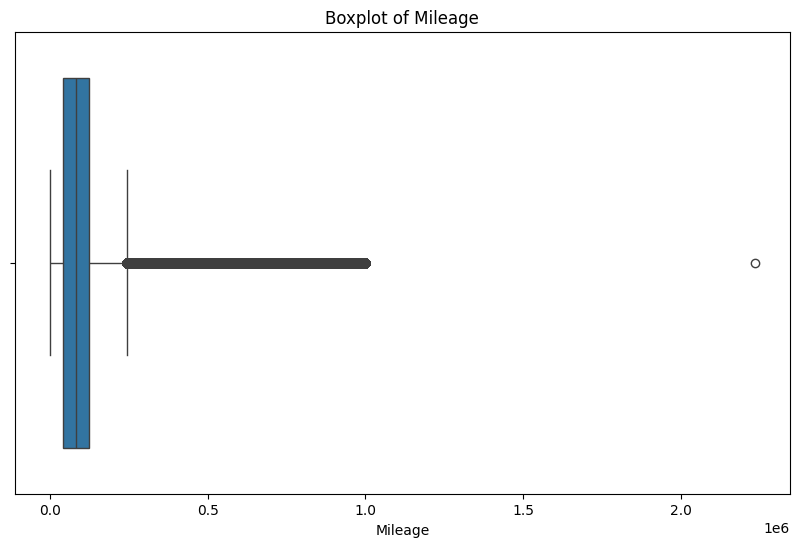

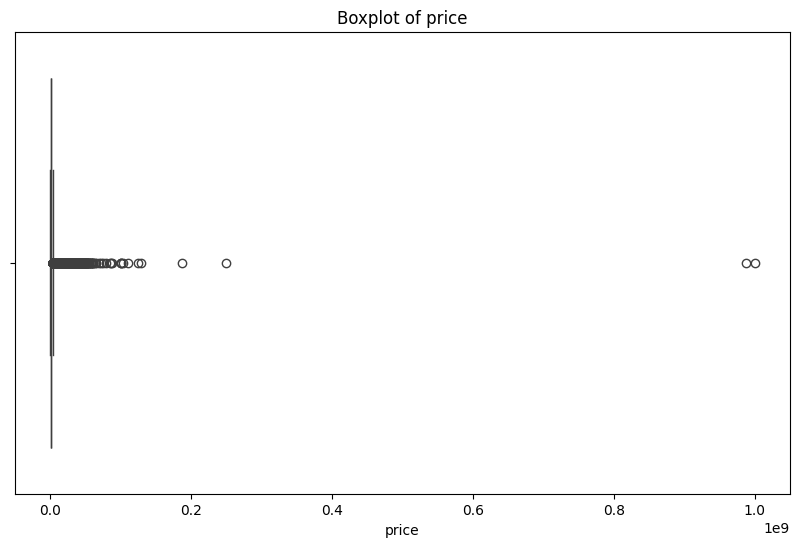

In [66]:
# Plot boxplots before outlier removal
plot_boxplot(df, 'mileage', title='Boxplot of Mileage', xlabel='Mileage')
plot_boxplot(df, 'price', title='Boxplot of price', xlabel='price')


In [67]:
df= remove_outliers(df, 'mileage')
df= remove_outliers(df, 'price')

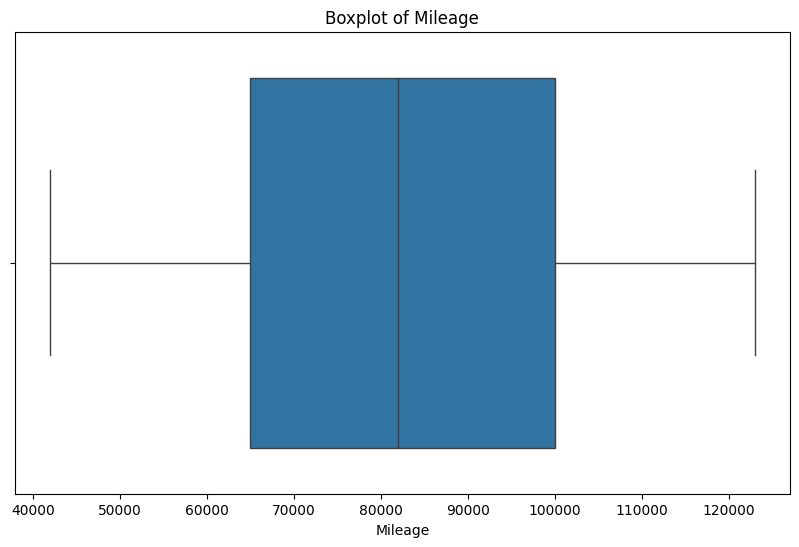

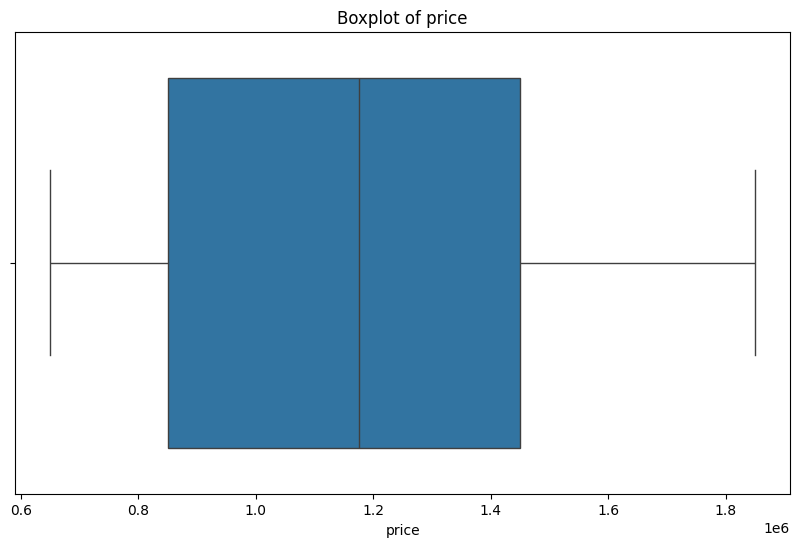

In [68]:
# Plot boxplots after outlier removal
plot_boxplot(df, 'mileage', title='Boxplot of Mileage', xlabel='Mileage')
plot_boxplot(df, 'price', title='Boxplot of price', xlabel='price')

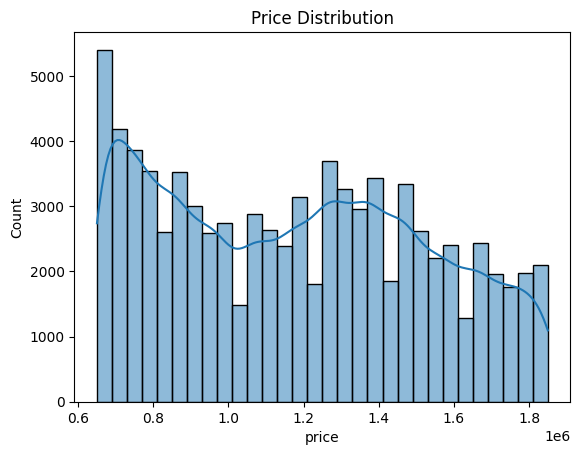

In [69]:
visualize_distribution(df['price'], 'Price Distribution')

### Visualizing the Relationship between Year and Mileage for the Same MMS
In this section, we visualize the relationship between the 'year' and 'mileage' columns for the same Maker-Model-Submodel (MMS). The process involves filtering the DataFrame based on user input for the 'MMS' value, creating mileage categories for the filtered DataFrame, and then plotting the relationship .

In [70]:
df_by_MMS = filter_by_MMS_input(df)

Possible 'MMS' values (sorted by frequency in descending order): ['86-912-956', '86-912-957', '35-342-990', '35-342-987', '86-918-675', '86-912-667', '35-341-984', '66-687-779', '86-928-664', '64-661-946', '86-912-955', '86-912-669', '35-341-987', '86-930-667', '37-373-1019', '83-880-622', '35-342-988', '60-592-438', '35-349-986', '86-930-968', '35-339-986', '35-345-991', '66-682-788', '86-930-675', '66-716-779', '58-560-420', '66-691-779', '44-467-1017', '35-342-985', '60-597-478', '35-341-983', '66-692-779', '66-697-587', '35-349-992', '86-912-952', '60-592-439', '64-1025-949', '66-717-976', '86-912-958', '86-928-669', '8-75-166', '86-924-965', '60-592-442', '66-704-779', '8-75-169', '86-935-669', '86-935-952', '66-697-975', '60-597-480', '86-912-670', '73-773-609', '86-924-666', '66-716-784', '66-682-789', '35-348-992', '43-441-761', '37-373-1021', '8-75-164', '60-597-485', '35-335-985', '86-912-953', '44-467-1014', '60-607-550', '86-912-954', '83-880-623', '86-927-961', '60-592-440

In [71]:
display(df_by_MMS)

,make_id,model_id,submodel_id,price,mileage,country_code,year,currency,updated_at,age,MM,MMS
329,86,912.0,956.0,700000,100000,PK,2003,PKR,2019-06-22 21:50:03.898702+00:00,18,86-912,86-912-956
514,86,912.0,956.0,1550000,90000,PK,2010,PKR,2020-11-26 22:50:19.024057+00:00,11,86-912,86-912-956
558,86,912.0,956.0,1500000,100000,PK,2010,PKR,2021-02-22 10:04:25.014595+00:00,11,86-912,86-912-956
750,86,912.0,956.0,1800000,74000,PK,2013,PKR,2020-01-03 22:50:06.404056+00:00,8,86-912,86-912-956
827,86,912.0,956.0,1475000,123000,PK,2011,PKR,2020-11-04 22:50:24.070119+00:00,10,86-912,86-912-956
...,...,...,...,...,...,...,...,...,...,...,...,...
1047529,86,912.0,956.0,1560000,112000,PK,2011,PKR,2019-08-30 21:50:08.023653+00:00,10,86-912,86-912-956
1047824,86,912.0,956.0,1170000,120827,PK,2009,PKR,2019-09-25 21:50:05.777062+00:00,12,86-912,86-912-956
1047898,86,912.0,956.0,1650000,85000,PK,2010,PKR,2020-12-17 22:50:22.811448+00:00,11,86-912,86-912-956
1048380,86,912.0,956.0,1485000,120000,PK,2010,PKR,2020-12-15 22:50:24.012797+00:00,11,86-912,86-912-956


In [72]:
df_by_MMS= create_mileage_categories(df_by_MMS,4)

<ipython-input-28-e85f2dc4ffc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mileage_category'], bin_edges = pd.qcut(df['mileage'], q=num_ranges, retbins=True, labels=False)
<ipython-input-28-e85f2dc4ffc3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mileage_category'] = pd.cut(df['mileage'], bins=bin_edges, labels=bin_labels, include_lowest=True)


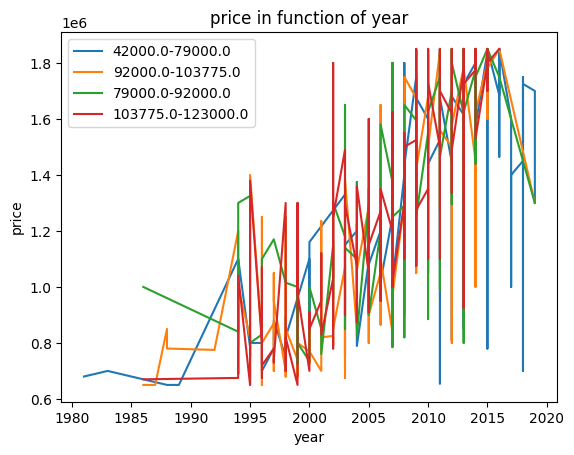

In [73]:
plot_price_vs_year(df_by_MMS)

# Data Preprocessing and Training
This section details the data preprocessing and training pipeline for machine learning models, encompassing helper functions, data preprocessing steps, and the training/evaluation of machine learning models.





### helper functions

In [74]:
def plot_correlation_matrix(df, selected_features):
    """
    Plot the correlation matrix for selected features in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - selected_features: list of features to consider in the correlation matrix
    """
    correlation_matrix = df[selected_features].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cbar=True)
    plt.title('Correlation Matrix')
    plt.show()

In [75]:
def preprocess_data(df):
    """
    Preprocesses the input DataFrame for machine learning tasks by performing the following steps:

    1. Drops unnecessary columns: 'country_code', 'currency', 'updated_at', 'age'.
    2. Splits the data into features (X) and target variable (y), where 'price' is the target.
    3. Splits the data into training and testing sets using a test size of 20% and a random state of 42.
    4. Identifies numerical and categorical features in the feature set (X).
    5. Creates transformers for imputing missing values in numerical features and one-hot encoding categorical features.
    6. Applies a column transformer that applies the respective transformers to numerical and categorical features.
    7. Transforms the training and testing sets using the created column transformer.
    8. Retrieves the transformed feature names after one-hot encoding.
    9. Sets monotonic constraints based on the transformed feature names.

    Parameters:
    - df: pandas DataFrame, the input data containing features and the target variable.

    Returns:
    - X_train_processed: numpy array, the processed feature set for training.
    - X_test_processed: numpy array, the processed feature set for testing.
    - y_train: pandas Series, the target variable for training.
    - y_test: pandas Series, the target variable for testing.
    - monotone_constraints: list, monotonic constraints for the features based on predefined rules.

    Example:
    X_train_processed, X_test_processed, y_train, y_test, monotone_constraints = preprocess_data(input_df)
    """
    # Drop unnecessary columns
    columns_to_drop = ['country_code', 'currency', 'updated_at', 'age']
    df = df.drop(columns=columns_to_drop)

    # Split the data into features and target
    X = df.drop(columns=['price'])
    y = df['price']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define numerical and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Create transformers for numerical and categorical features
    numeric_transformer = SimpleImputer(strategy='mean')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Apply preprocessing to training and testing sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Retrieve transformed feature names after one-hot encoding
    transformed_feature_names = list(numeric_features) + list(
        preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

    # Set monotonic constraints
    monotone_constraints = [-1 if col == 'mileage' else 1 if col == 'year' else 0 for col in transformed_feature_names]

    return X_train_processed, X_test_processed, y_train, y_test, monotone_constraints

In [76]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates a list of machine learning models using the provided training and testing sets.

    Parameters:
    - models: list, a list of machine learning models to train and evaluate.
    - X_train: numpy array or pandas DataFrame, the feature set for training.
    - y_train: numpy array or pandas Series, the target variable for training.
    - X_test: numpy array or pandas DataFrame, the feature set for testing.
    - y_test: numpy array or pandas Series, the target variable for testing.

    Prints:
    - For each model in the list:
        - The model type (class name).
        - R-squared (R2) score calculated on the testing set.

    Example:
    models_to_try = [RandomForestRegressor(random_state=42), LinearRegression()]
    train_and_evaluate_models(models_to_try, X_train, y_train, X_test, y_test)
    """
    for model in models:
        # Display the model type
        print(f"\nModel: {type(model).__name__}")

        # Check if the model is an XGBoost Booster
        if isinstance(model, xgb.Booster):
            # If XGBoost Booster, create DMatrix for testing set and make predictions
            dtest = xgb.DMatrix(X_test)
            y_pred = model.predict(dtest)
        else:
            # If not XGBoost, fit the model on the training set and make predictions on the testing set
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate and display R-squared (R2) score
        r2 = r2_score(y_test, y_pred)
        print(f'R-squared (R2) Score: {r2}')

### Data preprocessing
In this section, we visualize the correlation between numerical features using a heatmap.

In [77]:
numeric_features = ['mileage', 'year', 'price', 'age']

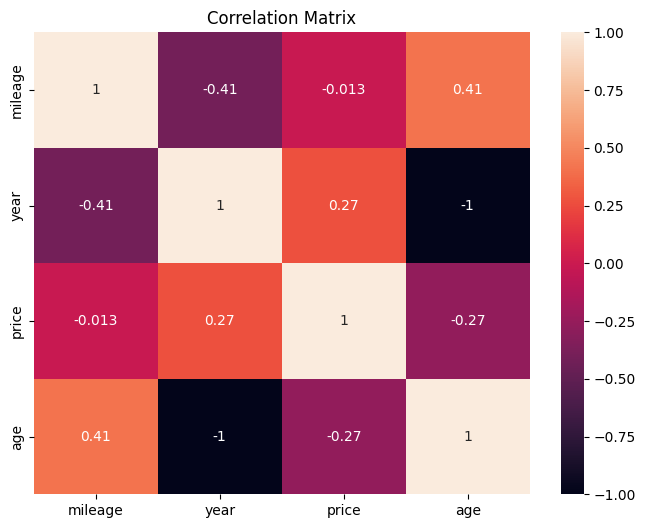

In [78]:
plot_correlation_matrix(df, numeric_features)

Observations: There is a strong correlation between 'age' and 'year'. We chose to drop the 'age' column in the next function.

Data Preprocessing Pipeline
Utilizes the preprocess_data function to perform a series of preprocessing steps:



*   Drops unnecessary columns.
*   Splits data into features and target variable.
*   Splits data into training and testing sets.
*   Identifies numerical and categorical features.
*   Creates transformers for imputing missing values and one-hot encoding.
*   Applies a column transformer to preprocess numerical and categorical features
*   Sets monotonic constraints based on the monotonicity of 'year' and 'mileage' with respect to 'price'.



In [79]:
X_train_processed, X_test_processed, y_train, y_test, monotone_constraints = preprocess_data(df)
monotone_constraints = tuple(monotone_constraints)

### Training and evaluation
In this section, different models are trained and evaluated: Random Forest, Linear Regression, XGBoost, and XGBoost with monotonic constraints. The evaluation is based on the R2 score, and the results may vary depending on the currency type chosen in earlier stages.

In [80]:
# Defining RandomForestRegressor and LinearRegression models
models_to_try = [
    RandomForestRegressor(random_state=42),
    LinearRegression(),
]

train_and_evaluate_models(models_to_try, X_train_processed, y_train, X_test_processed, y_test)


Model: RandomForestRegressor
R-squared (R2) Score: 0.7412766359038734

Model: LinearRegression
R-squared (R2) Score: 0.6142841802539412


In [81]:
dtest = xgb.DMatrix(X_test_processed)
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
evallist = [(dtrain, 'train')]
params_no_constraints = {
    'objective': 'reg:squarederror',
}
model_without_constraints = xgb.train(params_no_constraints, dtrain,
                                      num_boost_round=1000, evals=evallist,
                                      early_stopping_rounds=10)
y_pred_no_constraints = model_without_constraints.predict(dtest)


# Train and evaluate XGBoost with constraints
params_with_constraints = {
    'objective': 'reg:squarederror',
    'monotone_constraints': monotone_constraints,
}
model_with_constraints = xgb.train(params_with_constraints, dtrain,
                                   num_boost_round=1000, evals=evallist,
                                   early_stopping_rounds=10)
y_pred_with_constraints = model_with_constraints.predict(dtest)

[0]	train-rmse:283585.46212
[1]	train-rmse:241123.10274
[2]	train-rmse:214586.36853
[3]	train-rmse:199283.32828
[4]	train-rmse:189238.12369
[5]	train-rmse:182088.42130
[6]	train-rmse:177201.57658
[7]	train-rmse:174693.85858
[8]	train-rmse:172635.00899
[9]	train-rmse:171276.18343
[10]	train-rmse:170284.36554
[11]	train-rmse:169665.93279
[12]	train-rmse:169044.37965
[13]	train-rmse:168559.60247
[14]	train-rmse:168007.15074
[15]	train-rmse:167488.84916
[16]	train-rmse:167268.28097
[17]	train-rmse:166521.36191
[18]	train-rmse:166255.07767
[19]	train-rmse:165890.68313
[20]	train-rmse:165688.27758
[21]	train-rmse:165470.76917
[22]	train-rmse:165274.11640
[23]	train-rmse:165120.08739
[24]	train-rmse:164665.22565
[25]	train-rmse:164530.76889
[26]	train-rmse:164122.48395
[27]	train-rmse:164008.33005
[28]	train-rmse:163906.14527
[29]	train-rmse:163681.44087
[30]	train-rmse:162665.81269
[31]	train-rmse:162544.61520
[32]	train-rmse:162449.79039
[33]	train-rmse:162358.38507
[34]	train-rmse:162251.3

In [82]:
r2_no_constraints = r2_score(y_test, y_pred_no_constraints)
print(f'\nR2 Score without Constraints (XGBoost): {r2_no_constraints}')
r2_with_constraints = r2_score(y_test, y_pred_with_constraints)
print(f'\nR2 Score with Constraints (XGBoost): {r2_with_constraints}')


R2 Score without Constraints (XGBoost): 0.769869870371924

R2 Score with Constraints (XGBoost): 0.7705891419288986
